In [5]:
# imports
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler


# **Get Envirnonment Information**

In [ ]:
import sys
import numpy
import pandas as pd
import platform

print("Python:", sys.version)
print("Python executable:", sys.executable)
print("NumPy:", numpy.__version__)
print("Pandas:", pd.__version__)
print("System:", platform.system(), platform.machine())

# Alle noch verbleibenden Fehlklassifikationen (-1) aus dem Datensatz herausholen


In [ ]:
# path specification
tmp = "neu1"

# Pfad zur Eingabe- und Ausgabe-Pickle-Datei
input_path = Path("dataStage04/speechContent/electoral_term_20/speech_content.pkl")

# DataFrame laden
speech_content = pd.read_pickle(input_path)

# Zeilen mit faction_id == -1 und speech_content länger als 40 Zeichen herausfiltern
speech_content_nofaction = speech_content[
    speech_content["faction_id"].astype(str) == "-1"
]
speech_content_factions = speech_content[
    (speech_content["faction_id"].astype(str) != "-1")
]
speech_content_nofaaction_presidium = speech_content[
    (speech_content["faction_id"].astype(str) == "-1") & (speech_content["position_short"] != "Presidium of Parliament")
]
speech_content_factions_presidium = speech_content[
    (speech_content["faction_id"].astype(str) != "-1") & (speech_content["position_short"] != "Presidium of Parliament")
]

# Speichern in neuer Pickle-Datei
# speech_content_presidium.to_pickle(output_path_presidium)
# speech_content_factions.to_pickle(output_path_factions)

# make excel direction
output_path = Path(f"dataExcel/with_minister_{tmp}")
output_path.mkdir(parents=True, exist_ok=True)

# save excels
speech_content_nofaction.to_excel(f"dataExcel/with_minister_{tmp}/speech_content_20_nofaction_{tmp}.xlsx", index=False)
speech_content_factions.to_excel(f"dataExcel/with_minister_{tmp}/speech_content_20_faction_{tmp}.xlsx", index=False)
speech_content_nofaaction_presidium.to_excel(f"dataExcel/with_minister_{tmp}/speech_content_20_nofaction_presidium_{tmp}.xlsx", index=False)
speech_content_factions_presidium.to_excel(f"dataExcel/with_minister_{tmp}/speech_content_20_faction_presidium_{tmp}.xlsx", index=False)

print("done")

# Test speaker_id -> faction_id Zuweisung

In [ ]:
POLITICIANS = Path("dataStage03/dataPoliticiansStage03")

politicians = pd.read_csv(POLITICIANS / "politicians.csv")

speaker_id = 11003231


politician_rows = politicians[
    (politicians["ui"] == speaker_id) & (politicians["electoral_term"] == 20)
]

faction_id_candidate = -1

for fid in politician_rows["faction_id"].values:
    if fid != -1:
        faction_id_candidate = fid

print(faction_id_candidate)

politician_rows.to_csv("dataStage04/Testdatei.csv", index=False)

In [ ]:
LOOKUP = Path("dataStage03/dataPoliticiansStage03")
lookup = pd.read_csv(LOOKUP / "speaker_faction_lookup.csv")

speaker_id= 11002720
electoral_term = 20

row = lookup[(lookup["speaker_id"] == speaker_id) & (lookup["electoral_term"] == electoral_term)]

faction_id = int(row["faction_id"].iloc[0])

print(faction_id)

# **1 Initiale Datenbereinigung**

In [ ]:
# input paths
BASE_SPEECH_INPUT = Path("dataFinalStage/speechContentFinalStage")
BASE_CONTRIB_EXT_INPUT = Path("dataFinalStage/contributionsExtendedFinalStage")
BASE_CONTRIB_SIMPL_INPUT = Path("dataStage04/contributionsSimplified")

# output paths
BASE_OUTPUT_PICKLE = Path("dataPreprocessedStage/dataClassification/dataRelevant")
BASE_OUTPUT_EXCEL = Path("dataExcel/dataPreprocessed/dataClassification")
BASE_OUTPUT_EXCEL.mkdir(parents=True, exist_ok=True)
BASE_OUTPUT_PICKLE.mkdir(parents=True, exist_ok=True)

for term in [19, 20, "19_20"]:
    # define paths
    speech_input = BASE_SPEECH_INPUT / f"speech_content_{term}.pkl"
    speech_output_pickle = BASE_OUTPUT_PICKLE / f"speech_content_relevant_{term}.pkl"
    speech_output_excel = BASE_OUTPUT_EXCEL / f"speech_content_relevant_{term}.xlsx"

    contrib_ext_input = BASE_CONTRIB_EXT_INPUT / f"contributions_extended_{term}.pkl"
    contrib_ext_output = BASE_OUTPUT_PICKLE / f"contributions_extended_relevant_{term}.pkl"

    contrib_simpl_input = Path(f"dataStage04/contributionsSimplified/contributions_simplified_{term}.pkl")
    contrib_simpl_output = BASE_OUTPUT_PICKLE/ f"contributions_simplified_relevant_{term}.pkl"

    # load data
    speech_df = pd.read_pickle(speech_input)
    contrib_ext_df = pd.read_pickle(contrib_ext_input)
    contrib_simpl_df = pd.read_pickle(contrib_simpl_input)

    # filterlogic speeches
    valid_speeches = speech_df[
        (~speech_df["position_short"].isin(["Presidium of Parliament", "Guest"]))
        & (speech_df["faction_id"].astype(str) != "-1")
        #& (speech_df["speech_content"].str.len() > 70)
    ]

    # filtelogic contributions
    valid_ids = set(valid_speeches["id"])
    contrib_ext_filtered = contrib_ext_df[contrib_ext_df["speech_id"].isin(valid_ids)]
    contrib_simpl_filtered = contrib_simpl_df[contrib_simpl_df["speech_id"].isin(valid_ids)]

    # save data
    valid_speeches.to_pickle(speech_output_pickle)
    valid_speeches.to_excel(speech_output_excel, index=False)
    contrib_ext_filtered.to_pickle(contrib_ext_output)
    contrib_simpl_filtered.to_pickle(contrib_simpl_output)

    print(f"[{term}] → {len(valid_speeches)} Reden, {len(contrib_ext_filtered)} Extended-Contributions, {len(contrib_simpl_filtered)} Simplified")

In [1]:
import pandas

df = pandas.read_pickle("dataPreprocessedStage/dataClassification/speechContentCleaned/data_set_4_19.pkl")

df.to_excel("dataExcel/data_set_4_19.xlsx", index=False)

# **2 Text Cleaning and Normalization serial**

In [ ]:
import nltk
from pathlib import Path
from dataPreprocessingHelpers.preprocessing_pipeline import preprocess_speech_data
from dataPreprocessingHelpers.preprocessing_pipeline import ensure_required_nlp_resources

# NLTK-Ressourcen laden
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

# spaCy-Ressourcen laden (in der Shell oder im Jupyter-Notebook via "!")
!python -m spacy download de_core_news_sm

# custom regex patterns for phrase removal
from dataPreprocessingHelpers.phrase_patterns import PHRASE_PATTERNS_CLASSIFICATION_3

# domain-specific stopwords to enhance stopword removal standard lists
from dataPreprocessingHelpers.domain_stopwords import DOMAIN_SPECIFIC_STOPWORDS_CLASSIFICATION_1

ensure_required_nlp_resources()

# terms: numeric + kombi
terms = [19, 20, "19_20"]

# data set 1: full cleaning, domain specific spacy stopword removal, phrase pattern removal
for term in terms:
    preprocess_speech_data(
        input_path=Path(f"dataPreprocessedStage/dataClassification/dataRelevant/speech_content_relevant_{term}.pkl"),
        output_path_pickle=Path(f"dataPreprocessedStage/dataClassification/speechContentCleaned/data_set_1_{term}.pkl"),
        #output_path_excel=Path(f"dataExcel/dataPreprocessed/dataClassification/data_set_1_{term}.xlsx"),

        # NEW: Optional filters (deactivated here)
        position_short=["Presidium of Parliament", "Guest"],  # removes presidium/neutral moderation
        only_valid_faction_id=True,
        without_faction=None,
        change_faction=["3", "7"], # swap BSW to Die Linke
        generate_contributions_data=False,

        # Core text normalization
        contributions="REMOVE",
        to_lower=True,
        remove_digits=True,
        remove_punctuation=True,
        stopword_mode="SPACY",
        custom_stopwords=DOMAIN_SPECIFIC_STOPWORDS_CLASSIFICATION_1,
        phrase_patterns=PHRASE_PATTERNS_CLASSIFICATION_3,

        # Optional NLP metrics
        lemmatization=True,
        stemming=True,
        tokenization_method="SPACY",
        add_char_count=True,
        add_token_count=True,
        add_lemma_count=True
    )

# data set 2: full cleaning, spacy stopword removal, phrase pattern removal
for term in terms:
    preprocess_speech_data(
        input_path=Path(f"dataPreprocessedStage/dataClassification/dataRelevant/speech_content_relevant_{term}.pkl"),
        output_path_pickle=Path(f"dataPreprocessedStage/dataClassification/speechContentCleaned/data_set_2_{term}.pkl"),
        #output_path_excel=Path(f"dataExcel/dataPreprocessed/dataClassification/data_set_2_{term}.xlsx"),

        # NEW: Optional filters (deactivated here)
        position_short=["Presidium of Parliament", "Guest"],  # removes presidium/neutral moderation
        only_valid_faction_id=True,
        without_faction=None,
        change_faction=["3", "7"], # swap BSW to Die Linke
        generate_contributions_data=False,

        # Core text normalization
        contributions="REMOVE",
        to_lower=True,
        remove_digits=True,
        remove_punctuation=True,
        stopword_mode="SPACY",
        #custom_stopwords=DOMAIN_SPECIFIC_STOPWORDS_CLASSIFICATION_1,
        phrase_patterns=PHRASE_PATTERNS_CLASSIFICATION_3,

        # Optional NLP metrics
        lemmatization=True,
        stemming=True,
        tokenization_method="SPACY",
        add_char_count=True,
        add_token_count=True,
        add_lemma_count=True
    )

# data set 3: full cleaning, spacy stopword removal
for term in terms:
    preprocess_speech_data(
        input_path=Path(f"dataPreprocessedStage/dataClassification/dataRelevant/speech_content_relevant_{term}.pkl"),
        output_path_pickle=Path(f"dataPreprocessedStage/dataClassification/speechContentCleaned/data_set_3_{term}.pkl"),
        #output_path_excel=Path(f"dataExcel/dataPreprocessed/dataClassification/data_set_3_{term}.xlsx"),

        # NEW: Optional filters (deactivated here)
        position_short=["Presidium of Parliament", "Guest"],  # removes presidium/neutral moderation
        only_valid_faction_id=True,
        without_faction=None,
        change_faction=["3", "7"], # swap BSW to Die Linke
        generate_contributions_data=False,

        # Core text normalization
        contributions="REMOVE",
        to_lower=True,
        remove_digits=True,
        remove_punctuation=True,
        stopword_mode="SPACY",
        #custom_stopwords=DOMAIN_SPECIFIC_STOPWORDS_CLASSIFICATION_1,
        #phrase_patterns=PHRASE_PATTERNS_CLASSIFICATION_3,

        # Optional NLP metrics
        lemmatization=True,
        stemming=True,
        tokenization_method="SPACY",
        add_char_count=True,
        add_token_count=True,
        add_lemma_count=True
    )

# data set 4: full cleaning, phrase pattern removal
for term in terms:
    preprocess_speech_data(
        input_path=Path(f"dataPreprocessedStage/dataClassification/dataRelevant/speech_content_relevant_{term}.pkl"),
        output_path_pickle=Path(f"dataPreprocessedStage/dataClassification/speechContentCleaned/data_set_4_{term}.pkl"),
        #output_path_excel=Path(f"dataExcel/dataPreprocessed/dataClassification/data_set_4_{term}.xlsx"),

        # NEW: Optional filters (deactivated here)
        position_short=["Presidium of Parliament", "Guest"],  # removes presidium/neutral moderation
        only_valid_faction_id=True,
        without_faction=None,
        change_faction=["3", "7"], # swap BSW to Die Linke
        generate_contributions_data=False,

        # Core text normalization
        contributions="REMOVE",
        to_lower=True,
        remove_digits=True,
        remove_punctuation=True,
        #stopword_mode="SPACY",
        #custom_stopwords=DOMAIN_SPECIFIC_STOPWORDS_CLASSIFICATION_1,
        phrase_patterns=PHRASE_PATTERNS_CLASSIFICATION_3,

        # Optional NLP metrics
        lemmatization=True,
        stemming=True,
        tokenization_method="SPACY",
        add_char_count=True,
        add_token_count=True,
        add_lemma_count=True
    )

# data set 5: full cleaning
for term in terms:
    preprocess_speech_data(
        input_path=Path(f"dataPreprocessedStage/dataClassification/dataRelevant/speech_content_relevant_{term}.pkl"),
        output_path_pickle=Path(f"dataPreprocessedStage/dataClassification/speechContentCleaned/data_set_5_{term}.pkl"),
        #output_path_excel=Path(f"dataExcel/dataPreprocessed/dataClassification/data_set_5_{term}.xlsx"),

        # NEW: Optional filters (deactivated here)
        position_short=["Presidium of Parliament", "Guest"],  # removes presidium/neutral moderation
        only_valid_faction_id=True,
        without_faction=None,
        change_faction=["3", "7"], # swap BSW to Die Linke
        generate_contributions_data=False,

        # Core text normalization
        contributions="REMOVE",
        to_lower=True,
        remove_digits=True,
        remove_punctuation=True,
        #stopword_mode="SPACY",
        #custom_stopwords=DOMAIN_SPECIFIC_STOPWORDS_CLASSIFICATION_1,
        #phrase_patterns=PHRASE_PATTERNS_CLASSIFICATION_3,

        # Optional NLP metrics
        lemmatization=True,
        stemming=True,
        tokenization_method="SPACY",
        add_char_count=True,
        add_token_count=True,
        add_lemma_count=True
    )

# data set 6: no cleaning, spacy stop word removal
for term in terms:
    preprocess_speech_data(
        input_path=Path(f"dataPreprocessedStage/dataClassification/dataRelevant/speech_content_relevant_{term}.pkl"),
        output_path_pickle=Path(f"dataPreprocessedStage/dataClassification/speechContentCleaned/data_set_6_{term}.pkl"),
        #output_path_excel=Path(f"dataExcel/dataPreprocessed/dataClassification/data_set_6_{term}.xlsx"),

        # NEW: Optional filters (deactivated here)
        position_short=["Presidium of Parliament", "Guest"],  # removes presidium/neutral moderation
        only_valid_faction_id=True,
        without_faction=None,
        change_faction=["3", "7"], # swap BSW to Die Linke
        generate_contributions_data=False,

        # Core text normalization
        contributions="REMOVE",
        #to_lower=True,
        #remove_digits=True,
        #remove_punctuation=True,
        stopword_mode="SPACY",
        # custom_stopwords=DOMAIN_SPECIFIC_STOPWORDS_CLASSIFICATION_1,
        #phrase_patterns=PHRASE_PATTERNS_CLASSIFICATION_3,

        # Optional NLP metrics
        lemmatization=True,
        stemming=True,
        tokenization_method="SPACY",
        add_char_count=True,
        add_token_count=True,
        add_lemma_count=True
    )

# data set 7: cleaning (lowercase), domain specific spacy stopword removal
for term in terms:
    preprocess_speech_data(
        input_path=Path(f"dataPreprocessedStage/dataClassification/dataRelevant/speech_content_relevant_{term}.pkl"),
        output_path_pickle=Path(f"dataPreprocessedStage/dataClassification/speechContentCleaned/data_set_7_{term}.pkl"),
        #output_path_excel=Path(f"dataExcel/dataPreprocessed/dataClassification/data_set_7_{term}.xlsx"),

        # NEW: Optional filters (deactivated here)
        position_short=["Presidium of Parliament", "Guest"],  # removes presidium/neutral moderation
        only_valid_faction_id=True,
        without_faction=None,
        change_faction=["3", "7"], # swap BSW to Die Linke
        generate_contributions_data=False,

        # Core text normalization
        contributions="REMOVE",
        to_lower=True,
        # remove_digits=True,
        # remove_punctuation=True,
        stopword_mode="SPACY",
        custom_stopwords=DOMAIN_SPECIFIC_STOPWORDS_CLASSIFICATION_1,
        #phrase_patterns=PHRASE_PATTERNS_CLASSIFICATION_3,

        # Optional NLP metrics
        lemmatization=True,
        stemming=True,
        tokenization_method="SPACY",
        add_char_count=True,
        add_token_count=True,
        add_lemma_count=True
    )

# data set 8: no cleaning, phrase pattern removal
for term in terms:
    preprocess_speech_data(
        input_path=Path(f"dataPreprocessedStage/dataClassification/dataRelevant/speech_content_relevant_{term}.pkl"),
        output_path_pickle=Path(f"dataPreprocessedStage/dataClassification/speechContentCleaned/data_set_8_{term}.pkl"),
        #output_path_excel=Path(f"dataExcel/dataPreprocessed/dataClassification/data_set_8_{term}.xlsx"),

        # NEW: Optional filters (deactivated here)
        position_short=["Presidium of Parliament", "Guest"],  # removes presidium/neutral moderation
        only_valid_faction_id=True,
        without_faction=None,
        change_faction=["3", "7"], # swap BSW to Die Linke
        generate_contributions_data=False,

        # Core text normalization
        contributions="REMOVE",
        #to_lower=True,
        #remove_digits=True,
        #remove_punctuation=True,
        #stopword_mode="SPACY",
        #custom_stopwords=DOMAIN_SPECIFIC_STOPWORDS_CLASSIFICATION_1,
        phrase_patterns=PHRASE_PATTERNS_CLASSIFICATION_3,

        # Optional NLP metrics
        lemmatization=True,
        stemming=True,
        tokenization_method="SPACY",
        add_char_count=True,
        add_token_count=True,
        add_lemma_count=True
    )

# data set 9: cleaning (lowercase, remove digits, remove punctuation)
for term in terms:
    preprocess_speech_data(
        input_path=Path(f"dataPreprocessedStage/dataClassification/dataRelevant/speech_content_relevant_{term}.pkl"),
        output_path_pickle=Path(f"dataPreprocessedStage/dataClassification/speechContentCleaned/data_set_9_{term}.pkl"),
        #output_path_excel=Path(f"dataExcel/dataPreprocessed/dataClassification/data_set_9_{term}.xlsx"),

        # NEW: Optional filters (deactivated here)
        position_short=["Presidium of Parliament", "Guest"],  # removes presidium/neutral moderation
        only_valid_faction_id=True,
        without_faction=None,
        change_faction=["3", "7"], # swap BSW to Die Linke
        generate_contributions_data=False,

        # Core text normalization
        contributions="REMOVE",
        to_lower=True,
        # remove_digits=True,
        # remove_punctuation=True,
        stopword_mode="SPACY",
        custom_stopwords=DOMAIN_SPECIFIC_STOPWORDS_CLASSIFICATION_1,
        phrase_patterns=PHRASE_PATTERNS_CLASSIFICATION_3,

        # Optional NLP metrics
        lemmatization=True,
        stemming=True,
        tokenization_method="SPACY",
        add_char_count=True,
        add_token_count=True,
        add_lemma_count=True
    )

# data set 10: cleaning (lowercase), domain specific spacy stopword removal, phrae based removal
for term in terms:
    preprocess_speech_data(
        input_path=Path(f"dataPreprocessedStage/dataClassification/dataRelevant/speech_content_relevant_{term}.pkl"),
        output_path_pickle=Path(f"dataPreprocessedStage/dataClassification/speechContentCleaned/data_set_10_{term}.pkl"),
        #output_path_excel=Path(f"dataExcel/dataPreprocessed/dataClassification/data_set_10_{term}.xlsx"),

        # NEW: Optional filters (deactivated here)
        position_short=["Presidium of Parliament", "Guest"],  # removes presidium/neutral moderation
        only_valid_faction_id=True,
        without_faction=None,
        change_faction=["3", "7"], # swap BSW to Die Linke
        generate_contributions_data=False,

        # Core text normalization
        contributions="REMOVE",
        to_lower=True,
        # remove_digits=True,
        # remove_punctuation=True,
        stopword_mode="SPACY",
        custom_stopwords=DOMAIN_SPECIFIC_STOPWORDS_CLASSIFICATION_1,
        phrase_patterns=PHRASE_PATTERNS_CLASSIFICATION_3,

        # Optional NLP metrics
        lemmatization=True,
        stemming=True,
        tokenization_method="SPACY",
        add_char_count=True,
        add_token_count=True,
        add_lemma_count=True
    )

# **10 Globale Statistische Daten erzeugen**
# faction_stats
- Alle verschiedenen Parteien, die im Datensatz auftreten
- Anzahl der verschiedenen Redner:innen jeder Partei
- Anzahl der gehaltenen Reden pro Partei
- durchschnittliche Redelänge der einzelnen Reden der Parteien
- Standardabweichung der Längen der Reden der jeweiligen Partei im Vergleich zu der mittleren Länge aller Reden
# speaker_stats
- Alle verschiedenen Redner, die im Datensatz auftreten
- Anzahl der Reden, die die jeweilige Person gehalten hat
- Gesamte Rededauer, der Person (Character-Zahl)
- Durchschnittliche Dauer der Reden der Person
- durchschnittliche Redelänge einzelnen Reden der Politiker
- Standardabweichung der Länge der einzelnen Reden des jeweiligen Politikers im Vergleich zu der mittleren Länge aller Reden
# speech_global_stats
- Anzahl der unterschiedlichen Fraktionen
- Anzahl der unterschiedlichen Redner
- Längste Rede: Character-Zahl
- Kürzeste Rede: Character-Zahl
- Mittlere Rede: Character Zahl
- Durchschnittliche Character Anzahl pro Politiker
- Durchschnittliche Character Anzahl aller Reden

In [ ]:
# input paths
FACTIONS = Path("dataStage03/dataFactionsStage03/factionsAbbreviations.pkl")
SPEECH_FILES = {
    19: Path("dataPreprocessedStage/dataRelevant/speech_content_relevant_19.pkl"),
    20: Path("dataPreprocessedStage/dataRelevant/speech_content_relevant_20.pkl"),
    "19_20": Path("dataPreprocessedStage/dataRelevant/speech_content_relevant_19_20.pkl")
}

# output paths
OUTPUT_BASE_PICKLE = Path("dataMetrics")
OUTPUT_BASE_EXCEL = Path("dataExcel/dataMetrics")
OUTPUT_BASE_PICKLE .mkdir(parents=True, exist_ok=True)
OUTPUT_BASE_EXCEL.mkdir(parents=True, exist_ok=True)


# load faction data and remove duplicates
faction_df = pd.read_pickle(FACTIONS).drop_duplicates(subset="id")

def compute_stats(speech_df):
    # speeches lengths
    speech_df["speech_length"] = speech_df["speech_content"].str.len()

    # global metrics
    global_mean = speech_df["speech_length"].mean()
    global_std = speech_df["speech_length"].std(ddof = 1)
    min_speech = speech_df["speech_length"].min()
    max_speech = speech_df["speech_length"].max()
    median_speech = speech_df["speech_length"].median()

    # counts of factions and speakers
    unique_faction_count = speech_df["faction_id"].nunique()
    unique_speaker_count = speech_df["politician_id"].nunique()

    # faction stats
    faction_stats = speech_df.groupby(["faction_id", "abbreviation", "faction_name"]).agg(
        number_of_speeches=("id", "count"),
        total_characters=("speech_length", "sum"),
        avg_speech_length=("speech_length", lambda x: round(x.mean())),
        speech_length_std=("speech_length", lambda x: round(x.std(ddof=1), 2)),
        speech_length_std_vs_global_mean=("speech_length", lambda x: round(((x - global_mean) ** 2).mean() ** 0.5)),
        speaker_count=("politician_id", pd.Series.nunique)
    ).reset_index()

    # speaker stats
    speaker_stats = speech_df.groupby(["politician_id", "first_name", "last_name", "faction_id", "abbreviation"]).agg(
        number_of_speeches=("id", "count"),
        total_characters=("speech_length", "sum"),
        avg_speech_length=("speech_length", lambda x: round(x.mean())),
        speech_length_std_vs_global_mean=("speech_length", lambda x: round(((x - global_mean) ** 2).mean() ** 0.5))
    ).reset_index()

    # collect metrics
    speech_global_stats = {
        "unique_faction_count": unique_faction_count,
        "unique_speaker_count": unique_speaker_count,
        "longest_speech_characters": int(max_speech),
        "shortest_speech_characters": int(min_speech),
        "median_speech_characters": int(median_speech),
        "avg_characters_per_speaker": round(speech_df["speech_length"].sum() / unique_speaker_count) if unique_speaker_count > 0 else 0,
        "avg_characters_per_speech": round(global_mean),
        "global_speech_std": round(global_std)
    }

    return faction_stats, speaker_stats, speech_global_stats


# stat for both periods
all_speeches = []
for term, path in SPEECH_FILES.items():

    # load data
    speech_df = pd.read_pickle(path)

    # merge faction abbreviations
    speech_df = speech_df.merge(
        faction_df,
        how="left",
        left_on="faction_id",
        right_on="id",
        suffixes=('', '_faction')
    )
    all_speeches.append(speech_df)

    # compute data
    faction_stats, speaker_stats, speech_global_stats = compute_stats(speech_df)

    # save faction stats
    faction_stats.to_pickle(OUTPUT_BASE_PICKLE / f"faction_stats_{term}.pkl")
    faction_stats.to_excel(OUTPUT_BASE_EXCEL / f"faction_stats_{term}.xlsx", index=False)

    # save speaker stats
    speaker_stats.to_pickle(OUTPUT_BASE_PICKLE / f"speaker_stats_{term}.pkl")
    speaker_stats.to_excel(OUTPUT_BASE_EXCEL / f"speaker_stats_{term}.xlsx", index=False)

    # save metrics
    pd.Series(speech_global_stats).to_pickle(OUTPUT_BASE_PICKLE / f"speech_global_stats_{term}.pkl")
    pd.Series(speech_global_stats).to_excel(OUTPUT_BASE_EXCEL / f"speech_global_stats_{term}.xlsx")


# compute combined data
combined_df = pd.concat(all_speeches, ignore_index=True)
faction_stats, speaker_stats, speech_global_stats = compute_stats(combined_df)


# save faction stats
faction_stats.to_pickle(OUTPUT_BASE_PICKLE / f"faction_stats_{term}.pkl")
faction_stats.to_excel(OUTPUT_BASE_EXCEL / f"faction_stats_{term}.xlsx", index=False)

# save speaker stats
speaker_stats.to_pickle(OUTPUT_BASE_PICKLE / f"speaker_stats_{term}.pkl")
speaker_stats.to_excel(OUTPUT_BASE_EXCEL / f"speaker_stats_{term}.xlsx", index=False)

# save metrics
pd.Series(speech_global_stats).to_pickle(OUTPUT_BASE_PICKLE / f"speech_global_stats_{term}.pkl")
pd.Series(speech_global_stats).to_excel(OUTPUT_BASE_EXCEL / f"speech_global_stats_{term}.xlsx")


print("Alle Statistiken für Wahlperiode 19, 20 und kombiniert wurden erfolgreich erstellt und gespeichert.")

# Statistiken

## Alle Werte:
- Alle verschiedenen Parteien, die im Datensatz auftreten
- Alle verschiedenen Redner, die im Datensatz auftreten
- Anzahl der verschiedenen Redner:innen jeder Partei
- Anzahl der gehaltenen Reden pro Partei
- Anzahl der gehaltenen Reden pro Redner
- Durchschnittliche gehaltenen Reden pro Partei
- Durchschnittliche gehaltenen Reden pro Redner
- Gesamte Rededauer einer Partei
- Gesamte Rededauer eines Redners
- Längste Rede: Max Redezeit (pro Redner und pro Paretei)
- Kürzeste Rede: Min Redezeit (pro Redner und pro Paretei)
- Mittlere Rede: Median Redezeit (pro Redner und pro Paretei)
- Quartil der Redezeit (pro Redner und pro Paretei)
- Durchschnittliche Redezeit pro Redner
- Durchschnittliche Redezeit pro Partei
- Durchschnittliche Redezeit aller Reden
- Verteilung der Reden und Redezeit auf die Redner Innerhalb einer Partei
- Standardabweichung der Längen der Reden der jeweiligen Partei im Vergleich zu der mittleren Länge aller Reden
- Standardabweichung der Länge der einzelnen Reden des jeweiligen Politikers im Vergleich zu der mittleren Länge aller Reden
- Standardabweichung der Länge der einzelnen Reden des jeweiligen Politikers im Vergleich zu der mittleren Länge aller Reden seiner Partei
- Zeitliche Verteilung: Elche Parteien wann besonders viel Reden
- Prozentuale & absolute Verteilung der Klassen (Sowohl Reden, als auch Redezeit pro Klasse)

## Kombination aller Längen-Werte bei den Berechnungen:
- Kombination von speech_length_chars, speech_length_lemmas und speech_length_tokens:
    - Robustheit gegen Verzerrung: Wenn z. B. bei kurzen Reden viele Stoppwörter entfernt wurden, sinkt tokens stark, aber chars oder lemmas bleiben aussagekräftig.
    - Mehrdimensionale Filterung: Eine Rede mit wenigen Tokens, aber vielen Zeichen (z. B. Zahlen, Eigennamen) ist evtl. doch brauchbar.
    - Automatisierte Ausreißer-Erkennung wird präziser, wenn sie mehrere Maße gleichzeitig betrachtet (Multivariate Filter).
    - Was macht der Z-Score:
        - Nimmt den absoluten Z-Wert jeder Metrik (um zu ignorieren, ob ein Wert zu klein oder zu groß ist),
        - Bildet den arithmetischen Mittelwert der drei Werte.
        - Durch Standardisierung (Z-Scores) sind alle Metriken vergleichbar, obwohl sie unterschiedliche Größenordnungen haben.
        - Verwendung von Max statt Mittelwert (konservativer Filter): → Eine Rede ist schon dann auffällig, wenn eine Metrik ausreißt


## Automatische Datenpunkt Entfernung & Automatische Prüfung der Klassenverteilung
- Outlier-Erkennung: Extrem kurze/lange Reden werden basierend auf IQR (Interquartilsabstand) ausgeschlossen.
- Klassenfilter: Parteien mit sehr wenigen Reden werden ebenfalls entfernt (Grenze = 20 % des Durchschnitts).

Z-Score filtering bounds: 0.48 to 2.04
Removed 8757 speeches due to outlier speech length.
Remaining parties: ['CDU/CSU', 'SPD', 'Bündnis 90/Die Grünen', 'FDP', 'AfD', 'DIE LINKE.']
Parteien im Datensatz: ['SPD' 'CDU/CSU' 'FDP' 'AfD' 'DIE LINKE.' 'Bündnis 90/Die Grünen']
Anzahl verschiedener Redner: 753


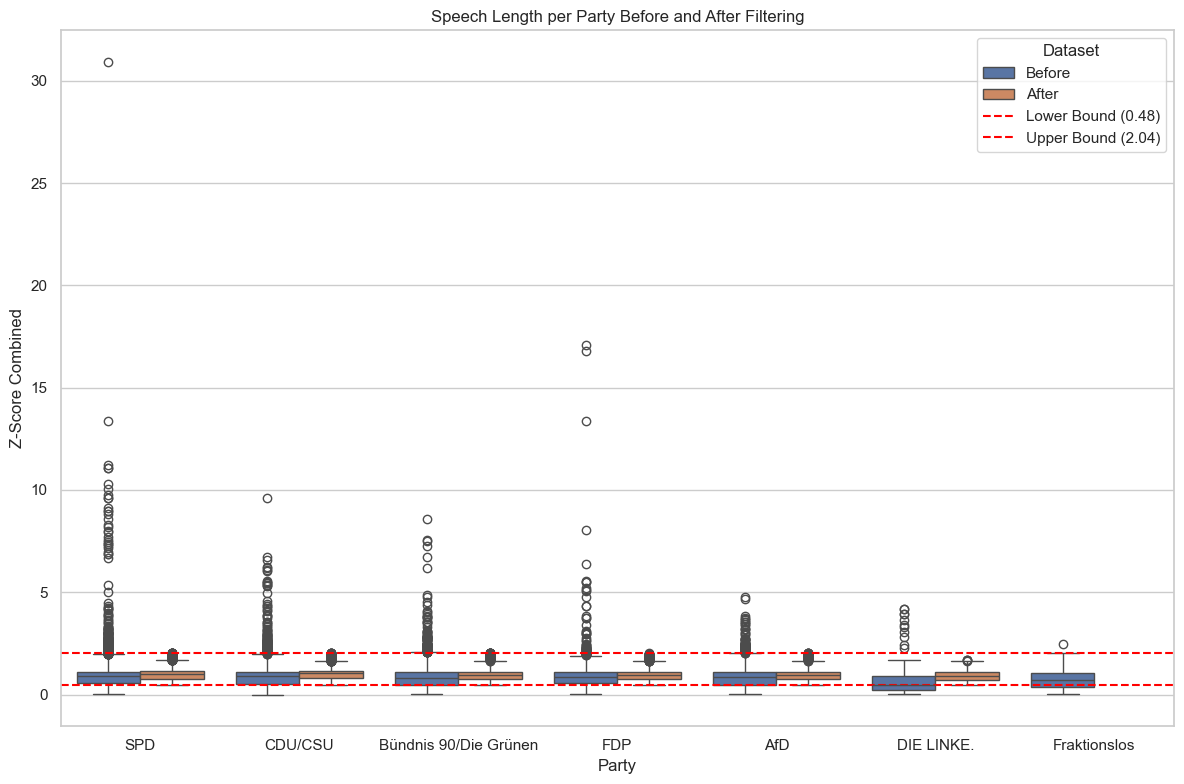

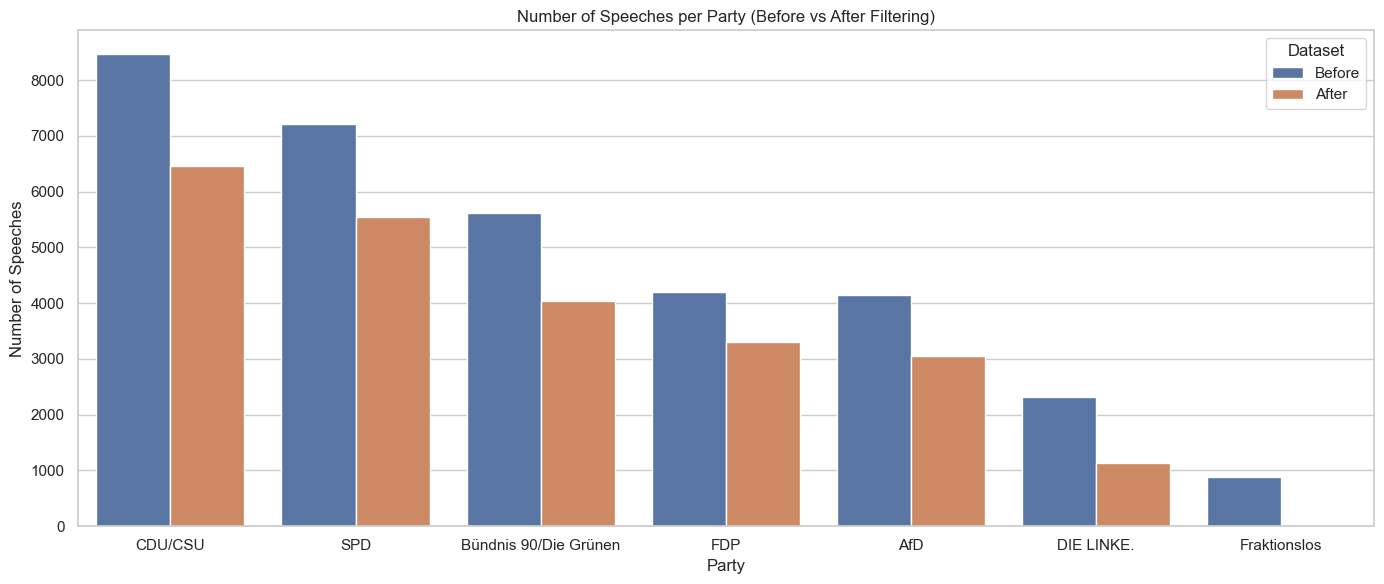

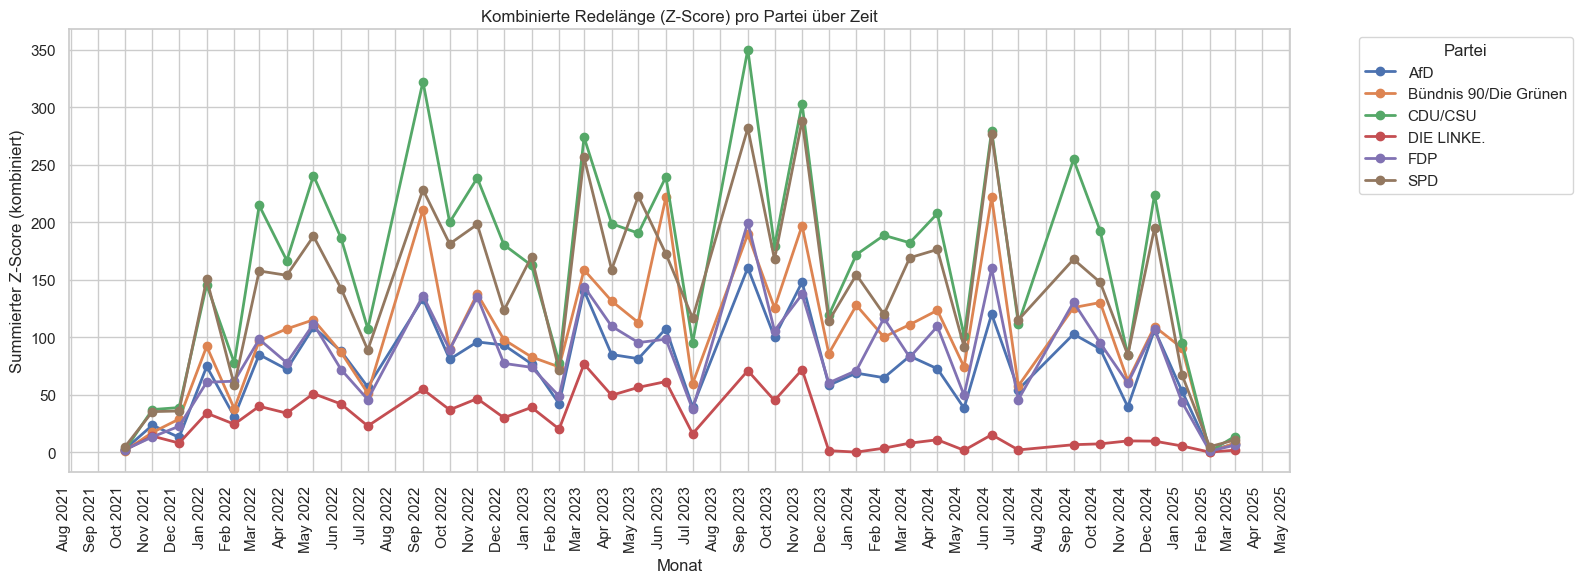

'\n# === Zeitreihe: Gestapeltes Balkendiagramm ===\nfig, ax = plt.subplots(figsize=(16, 6))\nbars = time_series.plot(kind=\'bar\', stacked=True, ax=ax)\n# Monatslabels erzwingen\nax.set_xticks(range(len(time_series.index)))\nax.set_xticklabels(time_series.index.strftime(\'%b %Y\'), rotation=90)\nplt.title("Kombinierte Redelänge (Z-Score) pro Partei – Monatlich (gestapelt)")\nplt.xlabel("Monat")\nplt.ylabel("Summierter Z-Score (kombiniert)")\nplt.legend(title="Partei", bbox_to_anchor=(1.05, 1), loc=\'upper left\')\nplt.tight_layout()\nplt.grid(True)\nplt.show()\n'

In [3]:
# Set global style for plots
sns.set(style="whitegrid")

# === CONFIG ===
DATA_PATH = "dataPreprocessedStage/dataClassification/speechContentCleaned/data_set_7_20.pkl"
FACTIONS = Path("dataStage03/dataFactionsStage03/factionsAbbreviations.pkl")
FACTION_COL = "faction_id"
SPEAKER_COL = "politician_id"
DATE_COL = "date"
LENGTH_COL = "z_score_combined"
TOK_COL = "speech_length_tokens"
CHAR_COL = "speech_length_chars"
LEMMA_COL = "speech_length_lemmas"
ABBREV_COL = "faction_abbreviation"


# === Load Data ===
df = pd.read_pickle(DATA_PATH)
df["date"] = pd.to_datetime(df["date"], unit='s')

# load faction data and remove duplicates
faction_df = pd.read_pickle(FACTIONS).drop_duplicates(subset="id")
faction_df = faction_df.rename(columns={"id": FACTION_COL, "abbreviation": ABBREV_COL})
# Merge in Haupt-DataFrame
df = df.merge(faction_df[[FACTION_COL, ABBREV_COL]], on=FACTION_COL, how="left")


# === Z-Score Kombination aus Tokens, Chars und Lemmas ===
df["z_tokens"] = (df[TOK_COL] - df[TOK_COL].mean()) / df[TOK_COL].std()
df["z_chars"] = (df[CHAR_COL] - df[CHAR_COL].mean()) / df[CHAR_COL].std()
df["z_lemmas"] = (df[LEMMA_COL] - df[LEMMA_COL].mean()) / df[LEMMA_COL].std()
df["z_score_combined"] = df[["z_tokens", "z_chars", "z_lemmas"]].abs().max(axis=1)


# copy for plt
df_old = df.copy()


# === OUTLIER FILTERING USING IQR ===
Q1 = df["z_score_combined"].quantile(0.25)
Q3 = df["z_score_combined"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1
upper_bound = Q3 + 3 * IQR

print(f"Z-Score filtering bounds: {lower_bound:.2f} to {upper_bound:.2f}")

before_len = len(df)
df = df[(df["z_score_combined"] >= lower_bound) & (df["z_score_combined"] <= upper_bound)]
print(f"Removed {before_len - len(df)} speeches due to outlier speech length.")


# === CLASS SIZE FILTERING ===
min_speeches = df[ABBREV_COL].value_counts().mean() * 0.2  # 20% of average
valid_parties = df[ABBREV_COL].value_counts()[lambda x: x >= min_speeches].index
df = df[df[ABBREV_COL].isin(valid_parties)]
print(f"Remaining parties: {valid_parties.tolist()}")


# === Partei- und Rednerübersicht ===
print("Parteien im Datensatz:", df[ABBREV_COL].unique())
print("Anzahl verschiedener Redner:", df[SPEAKER_COL].nunique())


# === Statistiken ===
speech_counts_party = df[ABBREV_COL].value_counts()
speech_counts_speaker = df[SPEAKER_COL].value_counts()
speaker_per_party = df.groupby(ABBREV_COL)[SPEAKER_COL].nunique()

# Gesamte "Länge" pro Partei und Redner (kombiniert)
total_combined_party = df.groupby(ABBREV_COL)["z_score_combined"].sum()
total_combined_speaker = df.groupby(SPEAKER_COL)["z_score_combined"].sum()

# Statistiken auf Basis der kombinierten Länge
speech_stats_party = df.groupby(ABBREV_COL)["z_score_combined"].agg(['min', 'median', 'max', 'mean', 'std', 'count'])
speech_stats_speaker = df.groupby(SPEAKER_COL)["z_score_combined"].agg(['min', 'median', 'max', 'mean', 'std', 'count'])

avg_combined_all = df["z_score_combined"].mean()
std_combined_all = df["z_score_combined"].std()


# === Z-Score Abweichung auf kombinierter Basis ===
df["std_to_global"] = (df["z_score_combined"] - avg_combined_all) / std_combined_all
df["std_to_party"] = df.groupby(ABBREV_COL)["z_score_combined"].transform(lambda x: (x - x.mean()) / x.std())


# === Zeitliche Verteilung ===
df["month"] = df[DATE_COL].dt.to_period("M")
# aggregierte kombinierte Redelänge je Partei und Monat
time_series = df.groupby(["month", ABBREV_COL])["z_score_combined"].sum().unstack(fill_value=0)

# Quartile der kombinierten Länge pro Redner und Partei
quartiles_party = df.groupby(ABBREV_COL)["z_score_combined"].quantile([0.25, 0.75]).unstack()
quartiles_speaker = df.groupby(SPEAKER_COL)["z_score_combined"].quantile([0.25, 0.75]).unstack()

# Prozentuale Verteilung der Reden pro Partei
speech_percent_party = 100 * speech_counts_party / speech_counts_party.sum()

# Prozentuale Verteilung der kombinierten Redezeit pro Partei
combined_percent_party = 100 * total_combined_party / total_combined_party.sum()

# Verteilung der kombinierten Redezeit auf Redner innerhalb der Partei
distribution_speaker_party = df.groupby([FACTION_COL, SPEAKER_COL])["z_score_combined"].agg(['count', 'sum', 'mean'])



df.to_pickle("dataPreprocessedStage/dataClassification/speechContentPreprocessed/data_set_7_20.pkl")


# === VISUALISIERUNGEN ===


# === Boxplot Redezeiten ===
"""
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x=ABBREV_COL, y=LENGTH_COL, showfliers=True)
plt.title("Speech Lengths per Party (Boxplot)")
plt.xlabel("Party")
plt.ylabel("Tokens per Speech")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
"""


# === BOXPLOT WITH BOUNDARIES ===
"""
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_old, x=ABBREV_COL, y="z_score_combined", showfliers=True)
plt.axhline(lower_bound, color="red", linestyle="--", label=f"Lower Bound ({lower_bound:.2f})")
plt.axhline(upper_bound, color="red", linestyle="--", label=f"Upper Bound ({upper_bound:.2f})")
plt.title("Speech Length per Party (Z-Score Combined)")
plt.ylabel("Z-Score Combined")
plt.xlabel("Party")
plt.legend()
plt.tight_layout()
plt.show()
"""


# === Gruppierter Boxplot df_old und df ===
df_old["Status"] = "Before"
df["Status"] = "After"
# Kombinieren
df_combined = pd.concat([df_old, df], axis=0)
# Gruppierter Boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_combined, x=ABBREV_COL, y="z_score_combined", hue="Status", showfliers=True)
plt.axhline(lower_bound, color="red", linestyle="--", label=f"Lower Bound ({lower_bound:.2f})")
plt.axhline(upper_bound, color="red", linestyle="--", label=f"Upper Bound ({upper_bound:.2f})")
plt.title("Speech Length per Party Before and After Filtering")
plt.xlabel("Party")
plt.ylabel("Z-Score Combined")
plt.xticks(rotation=0)
plt.legend(title="Dataset", loc="upper right")
plt.tight_layout()
plt.show()


"""
# === Reden pro Partei ===
plt.figure(figsize=(12, 6))
sns.barplot(x=speech_counts_party.index, y=speech_counts_party.values)
plt.title("Number of Speeches per Party")
plt.ylabel("Count")
plt.xlabel("Party")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
"""


"""
# === FINAL CLASS DISTRIBUTION PLOT ===
plt.figure(figsize=(12, 6))
speech_counts_party = df[ABBREV_COL].value_counts()
sns.barplot(x=speech_counts_party.index, y=speech_counts_party.values)
plt.title("Final Speech Count per Party")
plt.ylabel("Number of Speeches")
plt.xlabel("Party")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
"""


# === Erzeuge Redenzählung pro Partei in beiden DataFrames ===
speech_counts_before = df_old[ABBREV_COL].value_counts().reset_index()
speech_counts_before.columns = ["Party", "count"]
speech_counts_before["Status"] = "Before"

speech_counts_after = df[ABBREV_COL].value_counts().reset_index()
speech_counts_after.columns = ["Party", "count"]
speech_counts_after["Status"] = "After"

# Combine both DataFrames
speech_counts_combined = pd.concat([speech_counts_before, speech_counts_after])

# === Gruppierter Barplot ===
plt.figure(figsize=(14, 6))
sns.barplot(data=speech_counts_combined, x="Party", y="count", hue="Status")
plt.title("Number of Speeches per Party (Before vs After Filtering)")
plt.ylabel("Number of Speeches")
plt.xlabel("Party")
plt.xticks(rotation=0)
plt.legend(title="Dataset", loc="upper right")
plt.tight_layout()
plt.show()


# === Zeitreihe: Kombinierte Redezeit ===
time_series.index = time_series.index.to_timestamp()
# Erstelle den Plot
fig, ax = plt.subplots(figsize=(16, 6))  # Deutlich größere Plotgröße
time_series.plot(kind='line', linewidth=2, marker='o', ax=ax)
plt.title("Kombinierte Redelänge (Z-Score) pro Partei über Zeit")
plt.xlabel("Monat")
plt.ylabel("Summierter Z-Score (kombiniert)")
# Monatliches Labeln der x-Achse
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Jeder Monat
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # z.B. "Jan 2022"
plt.xticks(rotation=90)
# Legende & Layout
plt.legend(title="Partei", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


"""
# === Zeitreihe: Gestapeltes Balkendiagramm ===
fig, ax = plt.subplots(figsize=(16, 6))
bars = time_series.plot(kind='bar', stacked=True, ax=ax)
# Monatslabels erzwingen
ax.set_xticks(range(len(time_series.index)))
ax.set_xticklabels(time_series.index.strftime('%b %Y'), rotation=90)
plt.title("Kombinierte Redelänge (Z-Score) pro Partei – Monatlich (gestapelt)")
plt.xlabel("Monat")
plt.ylabel("Summierter Z-Score (kombiniert)")
plt.legend(title="Partei", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()
"""

- Kombination von speech_length_chars, speech_length_lemmas und speech_length_tokens:
    - Robustheit gegen Verzerrung: Wenn z. B. bei kurzen Reden viele Stoppwörter entfernt wurden, sinkt tokens stark, aber chars oder lemmas bleiben aussagekräftig.
    - Mehrdimensionale Filterung: Eine Rede mit wenigen Tokens, aber vielen Zeichen (z. B. Zahlen, Eigennamen) ist evtl. doch brauchbar.
    - Automatisierte Ausreißer-Erkennung wird präziser, wenn sie mehrere Maße gleichzeitig betrachtet (Multivariate Filter).
    - Was macht der Z-Score:
        - Nimmt den absoluten Z-Wert jeder Metrik (um zu ignorieren, ob ein Wert zu klein oder zu groß ist),
        - Bildet den arithmetischen Mittelwert der drei Werte.
        - Durch Standardisierung (Z-Scores) sind alle Metriken vergleichbar, obwohl sie unterschiedliche Größenordnungen haben.
        - Verwendung von Max statt Mittelwert (konservativer Filter): → Eine Rede ist schon dann auffällig, wenn eine Metrik ausreißt

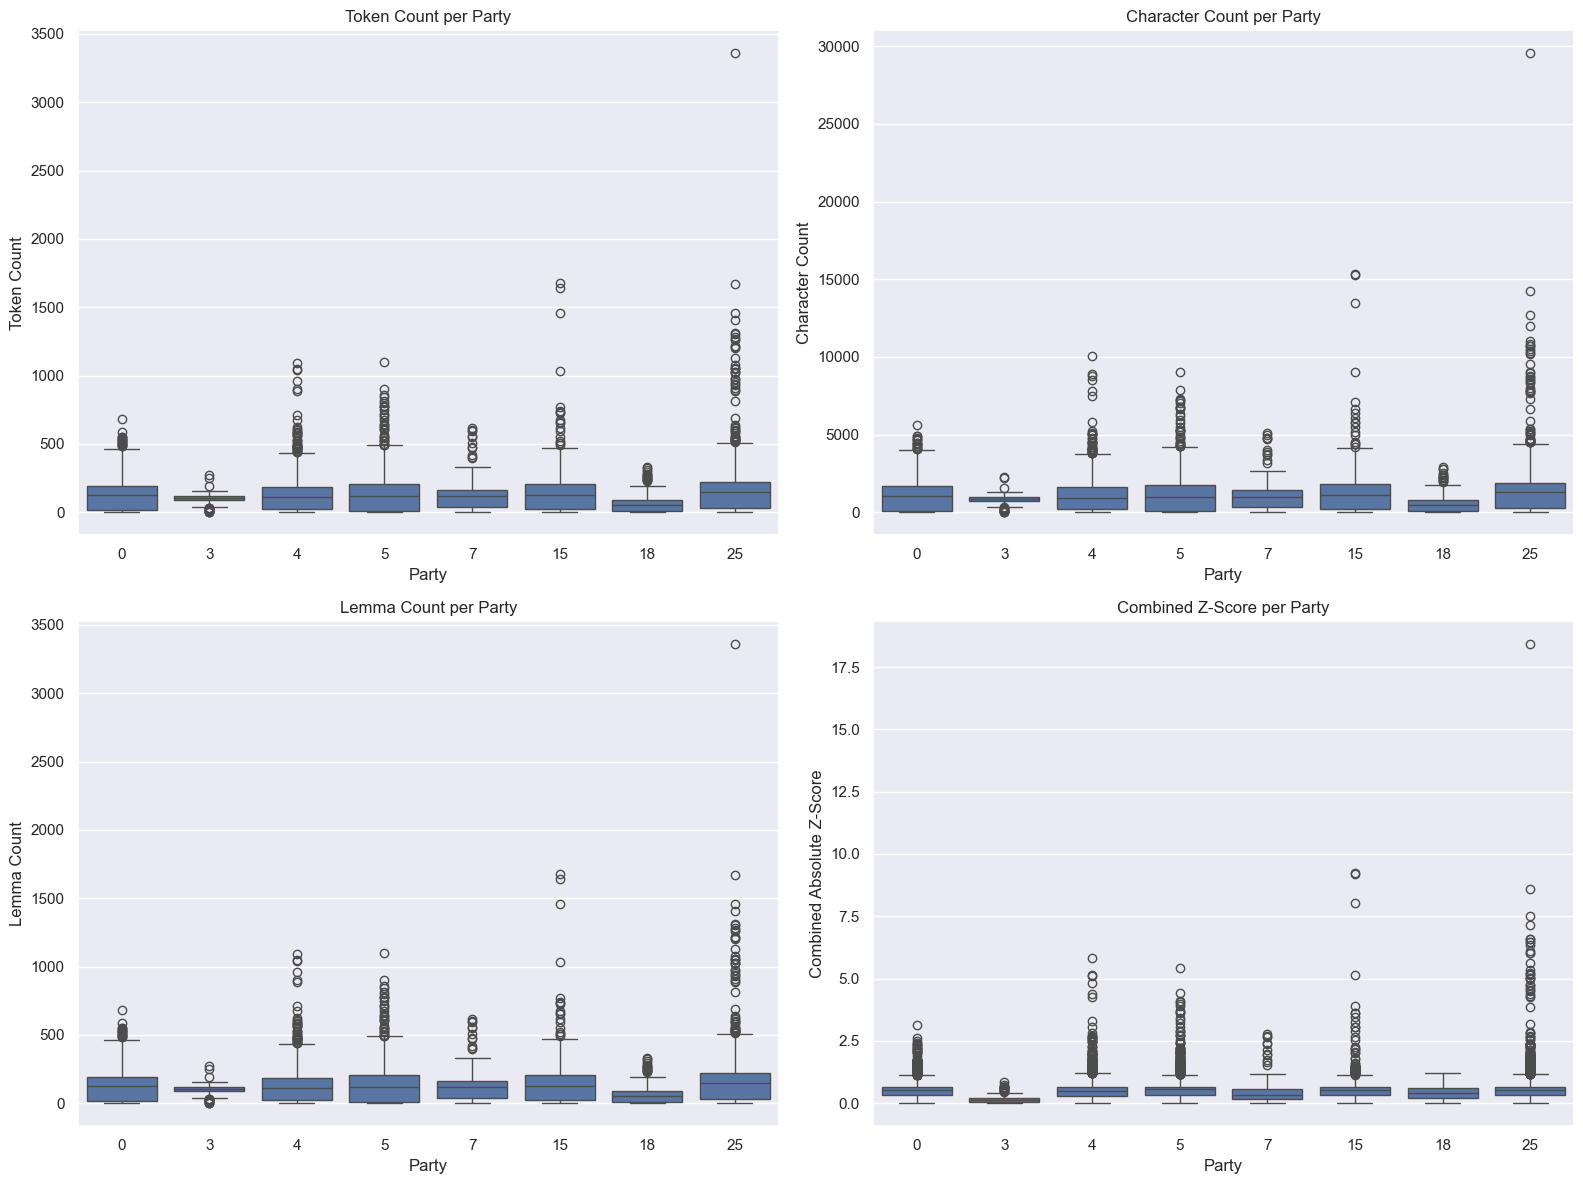

In [6]:
# load data
DATA_PATH = "dataPreprocessedStage/dataClassification/dataSets/data_set_1_20.pkl"
df = pd.read_pickle(DATA_PATH)

# Normalize all three features using the SKlearn RobustScaler
scaler = RobustScaler()
length_features = df[["speech_length_chars", "speech_length_tokens", "speech_length_lemmas"]]
normalized = scaler.fit_transform(length_features)
df[["norm_chars", "norm_tokens", "norm_lemmas"]] = normalized

# maximum absolute z-score across all three normalized features
df["z_score_combined"] = df[["norm_chars", "norm_tokens", "norm_lemmas"]].abs().max(axis=1)

# 2x2 visualisation to show the effects of normalization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Token Count Boxplot
sns.boxplot(data=df, x="faction_id", y="speech_length_tokens", ax=axes[0, 0])
axes[0, 0].set_title("Token Count per Party")
axes[0, 0].set_xlabel("Party")
axes[0, 0].set_ylabel("Token Count")

# Character Count Boxplot
sns.boxplot(data=df, x="faction_id", y="speech_length_chars", ax=axes[0, 1])
axes[0, 1].set_title("Character Count per Party")
axes[0, 1].set_xlabel("Party")
axes[0, 1].set_ylabel("Character Count")

# Lemma Count Boxplot
sns.boxplot(data=df, x="faction_id", y="speech_length_lemmas", ax=axes[1, 0])
axes[1, 0].set_title("Lemma Count per Party")
axes[1, 0].set_xlabel("Party")
axes[1, 0].set_ylabel("Lemma Count")

# conbined z-score boxplot
sns.boxplot(data=df, x="faction_id", y="z_score_combined", ax=axes[1, 1])
axes[1, 1].set_title("Combined Z-Score per Party")
axes[1, 1].set_xlabel("Party")
axes[1, 1].set_ylabel("Combined Absolute Z-Score")

plt.tight_layout()
plt.show()

# **Visualize Speech Removal with max Z-Score combination**

Removed 9985 speeches due to outlier speech length.


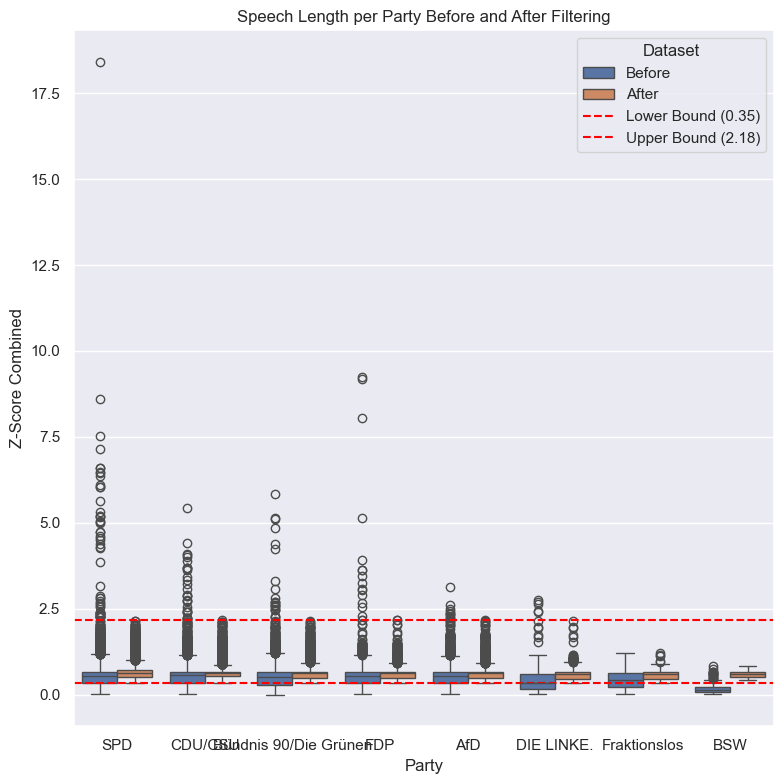

In [8]:
FACTION_COL = "faction_id"
ABBREV_COL = "faction_abbreviation"

# load data
DATA_PATH = "dataPreprocessedStage/dataClassification/dataSets/data_set_1_20.pkl"
df = pd.read_pickle(DATA_PATH)

# load faction data and remove duplicates
faction_df = pd.read_pickle("dataStage03/dataFactionsStage03/factionsAbbreviations.pkl").drop_duplicates(subset="id")
faction_df = faction_df.rename(columns={"id": FACTION_COL, "abbreviation": ABBREV_COL})
# Merge in Haupt-DataFrame
df = df.merge(faction_df[[FACTION_COL, ABBREV_COL]], on=FACTION_COL, how="left")

# Normalize all three features using the SKlearn RobustScaler
scaler = RobustScaler()
length_features = df[["speech_length_chars", "speech_length_tokens", "speech_length_lemmas"]]
normalized = scaler.fit_transform(length_features)
df[["norm_chars", "norm_tokens", "norm_lemmas"]] = normalized

# maximum absolute z-score across all three normalized features
df["z_score_combined"] = df[["norm_chars", "norm_tokens", "norm_lemmas"]].abs().max(axis=1)

# copy for plt
df_old = df.copy()

# Outlier filtering using Quantils
Q1 = df["z_score_combined"].quantile(0.3)
Q3 = df["z_score_combined"].quantile(0.9)
IQR = Q3 - Q1
lower_bound = Q1
upper_bound = Q3 + 3 * IQR

before_len = len(df)
df = df[(df["z_score_combined"] >= lower_bound) & (df["z_score_combined"] <= upper_bound)]
print(f"Removed {before_len - len(df)} speeches due to outlier speech length.")

# === Gruppierter Boxplot df_old und df ===
df_old["Status"] = "Before"
df["Status"] = "After"
# Kombinieren
df_combined = pd.concat([df_old, df], axis=0)
# Gruppierter Boxplot
plt.figure(figsize=(8, 8))
sns.boxplot(data=df_combined, x=ABBREV_COL, y="z_score_combined", hue="Status", showfliers=True)
plt.axhline(lower_bound, color="red", linestyle="--", label=f"Lower Bound ({lower_bound:.2f})")
plt.axhline(upper_bound, color="red", linestyle="--", label=f"Upper Bound ({upper_bound:.2f})")
plt.title("Speech Length per Party Before and After Filtering")
plt.xlabel("Party")
plt.ylabel("Z-Score Combined")
plt.xticks(rotation=0)
plt.legend(title="Dataset", loc="upper right")
plt.tight_layout()
plt.show()

# **Count and analyze speeches exceeding 512 BERT tokens**

In [3]:
"""
Count and analyze speeches exceeding 512 BERT tokens.

:dependencies: transformers: for BERT tokenizer
               pandas: for loading DataFrame
               matplotlib: for plotting (optional)

:param: path (str): Path to the .pkl file containing the dataset.

:return: over_limit_count (int): Number of speeches with >512 BERT tokens.
"""

import pandas as pd
from transformers import BertTokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load the dataframe
df = pd.read_pickle("dataFinalStage/speechContentFinalStage/speech_content_20.pkl")

# Filter valid faction (excluding fraktionslos)
valid_ids = [0, 3, 4, 5, 7, 15, 25]
df = df[df["faction_id"].isin(valid_ids)].copy()

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")

# Tokenize and count tokens per speech
tqdm.pandas(desc="Tokenizing speeches")
df["token_count"] = df["speech_content"].progress_apply(lambda x: len(tokenizer.tokenize(x)))

# Filter speeches over BERT max length
df_overlimit = df[df["token_count"] > 512].copy()
df_overlimit["excess_tokens"] = df_overlimit["token_count"] - 512

# Print stats
over_limit_count = len(df_overlimit)
print(f"Number of speeches exceeding 512 BERT tokens: {over_limit_count}")
print("\nToken count statistics for speeches exceeding 512 tokens:")
print(df_overlimit["excess_tokens"].describe())

# Optional: Show histogram
plt.figure(figsize=(10, 6))
plt.hist(df_overlimit["excess_tokens"], bins=30, edgecolor='black')
plt.title("Distribution of Token Overflows (>512 tokens)")
plt.xlabel("Number of tokens above 512")
plt.ylabel("Number of speeches")
plt.grid(True)
plt.tight_layout()
plt.show()

0
0
0
0
0
0
0
0
0
0


# **Convert Datasets to Excel for checkups**

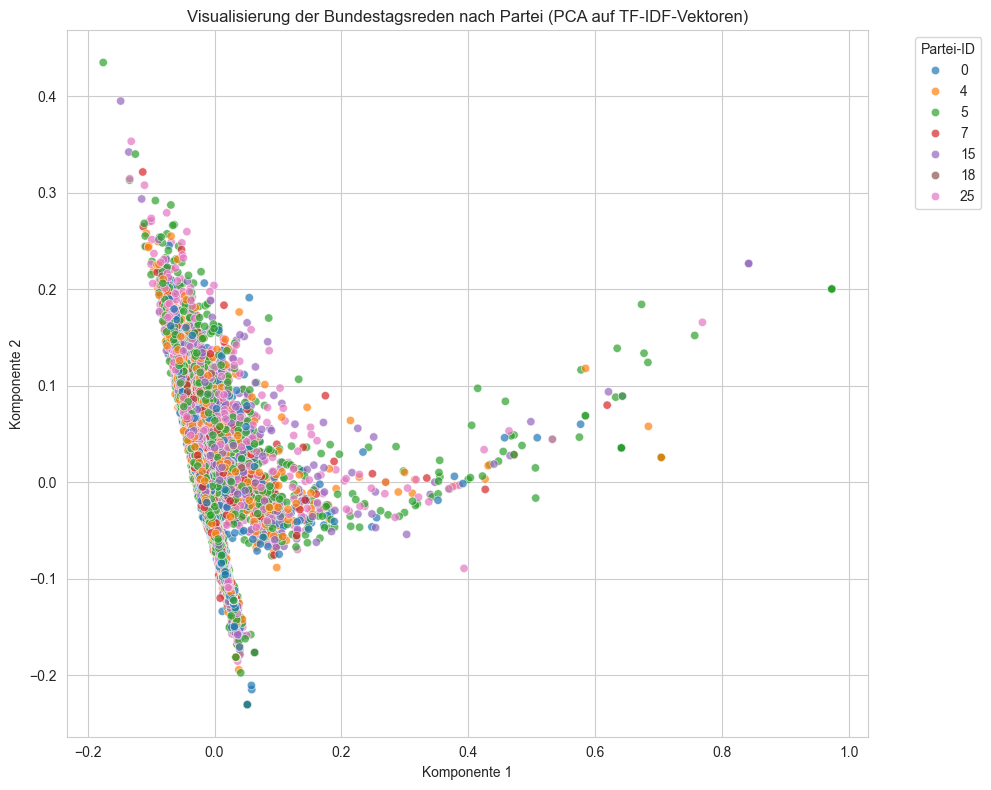

/opt/homebrew/Caskroom/miniconda/base/envs/nlp_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


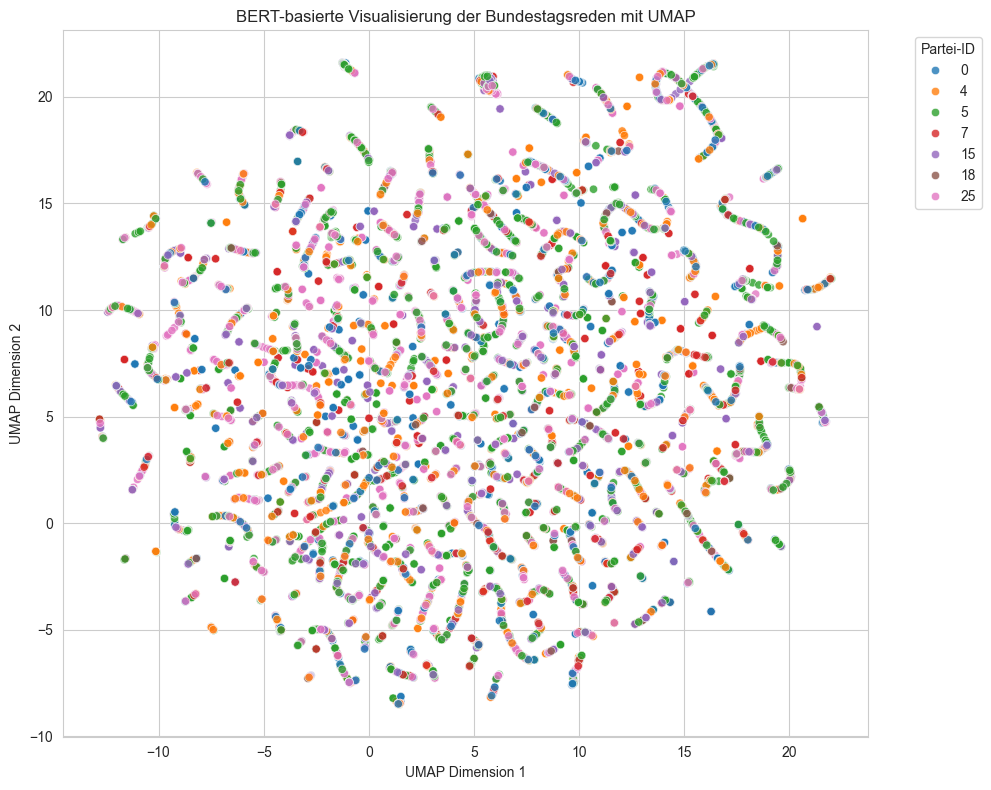

In [12]:
import pandas as pd
import os

for i in [
    1
    , 2
    , 3
    , 4
    , 5
    , 6
    , 7
    , 8
    , 9
    #, 10
    , 11]:
    for term in [19, 20, "19_20"]:
        path = f"dataPreprocessedStage/dataClassification/speechContentCleaned/data_set_{i}_{term}.pkl"
        if os.path.exists(path):
            df = pd.read_pickle(path)
            df.to_excel(f"dataExcel/dataPreprocessed/dataClassification/data_set_{i}_{term}.xlsx", index=False)
        else:
            print(f"Skipped missing file: {path}")
print("Done.")

# Prüfe of Token und Lemma Count gleich ist

/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_84136/3721614883.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = (df.groupby("faction_id", group_keys=False).apply(lambda x: x.sample(n=152, random_state=42)).reset_index(drop=True))
100%|██████████| 1216/1216 [01:55<00:00, 10.49it/s]
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by s

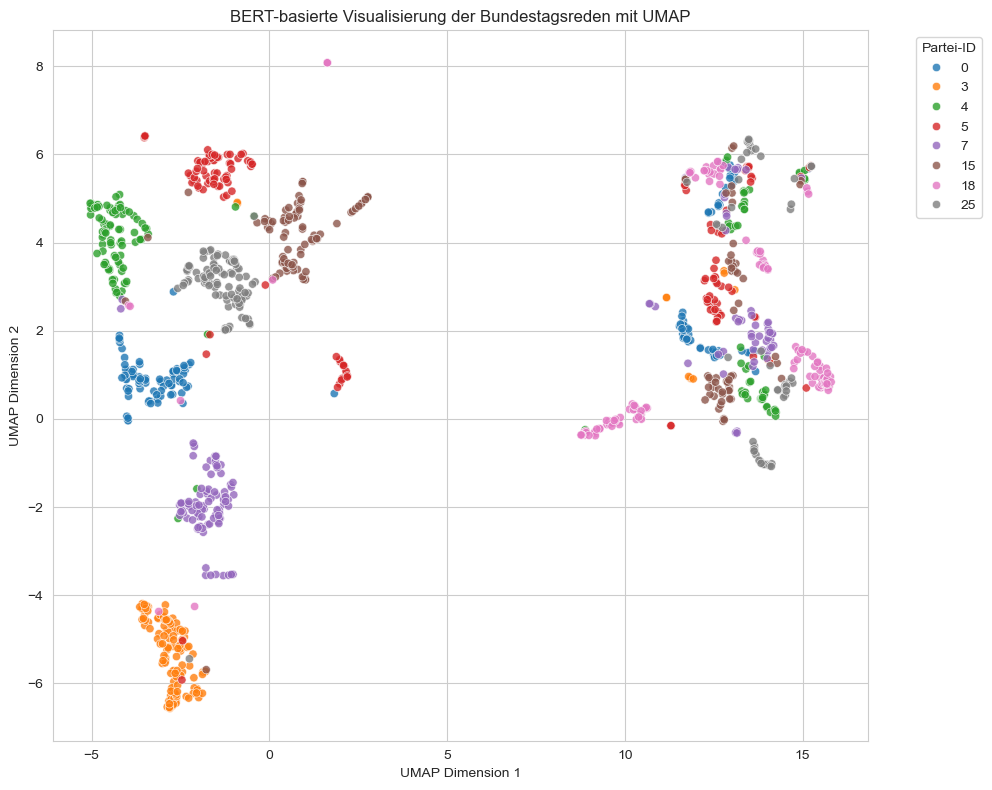

In [2]:
import pandas as pd

for i in [
    1
    , 2
    , 3
    , 4
    , 5
    , 6
    , 7
    , 8
    , 9
    #, 10
    , 11]:

    df = pd.read_pickle(f"dataPreprocessedStage/dataClassification/speechContentCleaned/data_set_{i}_19_20.pkl")

    count = (df["speech_length_lemmas"] != df["speech_length_tokens"]).sum()

    print(count)



# Feature Vektoren visualisieren

In [ ]:
# === Imports ===
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import seaborn as sns
import umap

# === Lade vorbereiteten Datensatz ===
df = pd.read_pickle("dataPreprocessedStage/dataClassification/speechContentCleaned/data_set_7_19_20.pkl")

# === Optional: Reduziere auf kleinere Menge für Performance bei t-SNE ===
df_sample = df.sample(n=20000, random_state=42)  # Für große Datensätze notwendig

# === Texte und Labels vorbereiten ===
texts = df_sample["speech_content_lemmatized"].tolist()
labels = df_sample["faction_id"].tolist()

# === Vektorisierung ===
vectorizer = TfidfVectorizer(max_features=20000)  # Begrenze auf 2000 Features für Übersichtlichkeit
X = vectorizer.fit_transform(texts)

# === Dimensionalitätsreduktion ===
# Variante 1: PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Variante 2: t-SNE (für nichtlineare Strukturen, schöner aber langsamer)
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# X_tsne = tsne.fit_transform(X.toarray())

# === Visualisierung ===
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=labels,
    palette="tab10",
    legend="full",
    alpha=0.7
)
plt.title("Visualisierung der Bundestagsreden nach Partei (PCA auf TF-IDF-Vektoren)")
plt.xlabel("Komponente 1")
plt.ylabel("Komponente 2")
plt.legend(title="Partei-ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# === UMAP für Visualisierung ===
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
X_umap = reducer.fit_transform(X_pca,  y=labels)

# === Plot ===
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_umap[:, 0], y=X_umap[:, 1],
    hue=labels,
    palette="tab10",
    alpha=0.8
)
plt.title("BERT-basierte Visualisierung der Bundestagsreden mit UMAP")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Partei-ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# === Lade Daten ===
df = pd.read_pickle("dataPreprocessedStage/dataClassification/speechContentCleaned/data_set_1_19_20.pkl")
df = df[df["speech_content_lemmatized"].notnull()]
df_sample = df.sample(n=1000, random_state=42)  # Für schnelle Visualisierung

texts = df_sample["speech_content"].tolist()
labels = df_sample["faction_id"].tolist()

# === BERT vorbereiten ===
tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")
model = BertModel.from_pretrained("bert-base-german-cased")
model.eval()

# === Funktion: mittlere BERT-Embeddings erzeugen ===
def get_mean_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding="max_length")
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state.squeeze(0)
    return last_hidden_state.mean(dim=0).numpy()

# === Embeddings berechnen ===
embeddings = [get_mean_embedding(text) for text in tqdm(texts)]

# === UMAP für Visualisierung ===
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
X_umap = reducer.fit_transform(embeddings)

# === Plot ===
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_umap[:, 0], y=X_umap[:, 1],
    hue=labels,
    palette="tab10",
    alpha=0.8
)
plt.title("BERT-basierte Visualisierung der Bundestagsreden mit UMAP")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Partei-ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# === Lade Daten ===
#df = pd.read_pickle("dataPreprocessedStage/dataClassification/speechContentCleaned/data_set_1_19_20.pkl")
df = pd.read_pickle("dataFinalStage/speechContentFinalStage/speech_content_20.pkl")
#df = df[df["speech_content_lemmatized"].notnull()]
df = df[
    (df["faction_id"].astype(str) != "-1")
]
df = df[
    (df["position_short"] != "Presidium of Parliament")
]
df = df[
    (df["position_short"] != "Guest")
]
# Sampling for quick processing
df_sample = (df.groupby("faction_id", group_keys=False).apply(lambda x: x.sample(n=152, random_state=42)).reset_index(drop=True))

texts = df_sample["speech_content"].tolist()
labels = df_sample["faction_id"].tolist()

# === BERT vorbereiten ===
tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")
model = BertModel.from_pretrained("bert-base-german-cased")
model.eval()

# === Funktion: mittlere BERT-Embeddings erzeugen ===
def get_mean_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding="max_length")
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state.squeeze(0)
    return last_hidden_state.mean(dim=0).numpy()

# === Embeddings berechnen ===
embeddings = [get_mean_embedding(text) for text in tqdm(texts)]

# === UMAP für Visualisierung ===
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
X_umap = reducer.fit_transform(embeddings,  y=labels)

# === Plot ===
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_umap[:, 0], y=X_umap[:, 1],
    hue=labels,
    palette="tab10",
    alpha=0.8
)
plt.title("BERT-basierte Visualisierung der Bundestagsreden reduziert mit UMAP")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Partei-ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# **Merging BSW into DIE LINKE.**

In [ ]:
# === Configuration ===
INPUT_DIR = Path("dataPreprocessedStage/dataClassification/dataSets_with_BSW")
OUTPUT_DIR = Path("dataPreprocessedStage/dataClassification/dataSets")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Process all .pkl files ===
for pkl_file in INPUT_DIR.glob("*.pkl"):
    df = pd.read_pickle(pkl_file)

    # Replace BSW (faction_id=3) with DIE LINKE (faction_id=7)
    bsw_count = (df["faction_id"] == 3).sum()
    if bsw_count > 0:
        print(f"[INFO] {pkl_file.name}: Replacing {bsw_count} rows (BSW → DIE LINKE)")

    df.loc[df["faction_id"] == 3, "faction_id"] = 7

    # Save to new directory with identical filename
    output_path = OUTPUT_DIR / pkl_file.name
    df.to_pickle(output_path)

print("\n✅ All files processed and saved to:", OUTPUT_DIR)